In [14]:
from functools import partial
import sys

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import torch
#import torch.nn as nn
#import torch.utils.data as data

import time
from itertools import product

import pyro
#import pyro.distributions as dist

import tyxe



In [2]:
#figdir = '/home/kpmurphy/github/rebayes/demos/figures' # TPU
figdir = '/Users/kpmurphy/github/rebayes/demos/figures' # laptop

In [15]:
import jax
import distrax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import flax.linen 
#import flax.linen as nn
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable
from tqdm.notebook import tqdm
from itertools import product
from jax.flatten_util import ravel_pytree
import jax.random as jr
from jax import vmap

import jax_dataloader.core as jdl

import rebayes
from rebayes import base
from rebayes.utils import uci_regression_data, datasets
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi, lrvga
from rebayes.sgd_filter import sgd

# Data

In [ ]:
def make_1d_regression_sequence_jax(n_dist=3, n_train=100, n_test=100, key=0, trenches=False, sort_data=False):
    c0 = jnp.linspace(start=2, stop=-1, num=n_dist)
    c1 = jnp.linspace(start=3, stop=-1, num=n_dist)
    coefs = jnp.vstack([c0,c1]).T
    def gen(c): return rebayes.utils.datasets.make_1d_regression(coef=c, n_train=n_train, n_test=n_test, key=key, trenches=trenches, sort_data=sort_data)
    X_train, y_train, X_test, y_test  = vmap(gen)(coefs)
    X_train = jnp.hstack(X_train[:,:,0])
    X_test = jnp.hstack(X_test[:,:,0])
    y_train = jnp.hstack(y_train[:,:,0])
    y_test = jnp.hstack(y_test[:,:,0])
    task_id_train = jnp.concatenate([i*jnp.ones(n_train) for i in range(n_dist)])
    task_id_test = jnp.concatenate([i*jnp.ones(n_test) for i in range(n_dist)])
    return X_train, y_train, X_test, y_test, task_id_train, task_id_test

def make_1d_regression_sequence(n_dist=3, n_train=100, n_test=100, key=0, trenches=False, sort_data=False):
    c0 = jnp.linspace(start=2, stop=-1, num=n_dist)
    c1 = jnp.linspace(start=3, stop=-1, num=n_dist)
    coefs = jnp.vstack([c0,c1]).T
    def gen(c): return rebayes.utils.datasets.make_1d_regression(coef=c, n_train=n_train, n_test=n_test, key=key, trenches=trenches, sort_data=sort_data)
    X_train, y_train, X_test, y_test  = vmap(gen)(coefs)
    X_train = np.hstack(X_train[:,:,0])
    X_test = np.hstack(X_test[:,:,0])
    y_train = np.hstack(y_train[:,:,0])
    y_test = np.hstack(y_test[:,:,0])
    task_id_train = np.concatenate([i*np.ones(n_train) for i in range(n_dist)])
    task_id_test = np.concatenate([i*np.ones(n_test) for i in range(n_dist)])
    #return X_train, y_train, X_test, y_test, task_id_train, task_id_test
    return X_train[:,np.newaxis], y_train[:,np.newaxis], X_test[:,np.newaxis], y_test[:,np.newaxis], task_id_train, task_id_test

def nonstat_regression_plot():
    X_train, y_train, X_test, y_test, task_id_train, task_id_test = make_1d_regression_sequence(n_dist=5)
    ntasks = len(np.unique(task_id_train))
    colors = ['r', 'g', 'b', 'k', 'c']
    plt.figure()
    for i in range(ntasks):
        ndx_train = (task_id_train == i)
        plt.plot(X_train[ndx_train], y_train[ndx_train], 'x', color=colors[i], label='train {:d}'.format(i))
        ndx_test = (task_id_test == i)
        plt.plot(X_test[ndx_test], y_test[ndx_test], 'o', color=colors[i], label='test {:d}'.format(i))
    plt.legend()
    
    fig, axs = plt.subplots(1,ntasks, figsize=(20,5))
    for i in range(ntasks):
        ax = axs[i]
        ndx_train = (task_id_train == i)
        ax.plot(X_train[ndx_train], y_train[ndx_train], 'x', color=colors[i], label='train {:d}'.format(i))
        ndx_test = (task_id_test == i)
        ax.plot(X_test[ndx_test], y_test[ndx_test], 'o', color=colors[i], label='test {:d}'.format(i))
    #plt.legend()

In [4]:
X_train, Y_train, X_test, Y_test, task_id_train, task_id_test = rebayes.utils.datasets.make_1d_regression_sequence(n_dist=5, n_train=200)

def get_task_data(i):
    ndx_train = (task_id_train == i)
    Xtr, ytr = X_train[ndx_train], Y_train[ndx_train]
    ndx_test = (task_id_test == i)
    Xte, yte = X_test[ndx_test], Y_test[ndx_test]
    return Xtr, ytr, Xte, yte


Xtr, ytr, Xte, yte = get_task_data(0)


In [17]:

def make_1d_regression(n_train=100, n_test=100, key=0, trenches=False, sort_data=False, coef=jnp.array([2.0,3.0]), sort_test=False):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key1, key2, subkey1, subkey2, key_shuffle = jr.split(key, 5)

    def gen(key, x):
        epsilons = jr.normal(key, shape=(3,))*0.02
        return (x + 0.3*jnp.sin(coef[0]*jnp.pi*(x+epsilons[0])) +
                0.3*jnp.sin(coef[1]*jnp.pi*(x+epsilons[1])) + epsilons[2])
    
    n_train_sample = 2 * n_train if trenches else n_train
    #X_train = jr.uniform(key1, shape=(n_train_sample, 1), minval=0.0, maxval=0.5)
    #X_test = jr.uniform(key2, shape=(n_test, 1), minval=0.0, maxval=0.5)
    X_train = jr.uniform(key1, shape=(n_train_sample, 1), minval=-0.5, maxval=0.5)
    X_test = jr.uniform(key2, shape=(n_test, 1), minval=-0.5, maxval=0.5)
    
    # sprt the test points for plotting 1d curves
    if sort_test:
        sorted_idx = jnp.argsort(X_test.squeeze())
        X_test = X_test[sorted_idx]

    keys_train = jr.split(subkey1, X_train.shape[0])
    keys_test = jr.split(subkey2, X_test.shape[0])
    y_train = vmap(gen)(keys_train, X_train)
    y_test = vmap(gen)(keys_test, X_test)

    # Standardize dataset
    X_train = (X_train - X_train.mean()) / X_train.std()
    y_train = (y_train - y_train.mean()) / y_train.std()
    X_test = (X_test - X_test.mean()) / X_test.std()
    y_test = (y_test - y_test.mean()) / y_test.std()

    if trenches:
        sorted_idx = jnp.argsort(X_train.squeeze())
        train_idx = jnp.concatenate([
            sorted_idx[:n_train//2], sorted_idx[2*n_train - n_train//2:]
        ])

        X_train, y_train = X_train[train_idx], y_train[train_idx]

    if not sort_data:
        n_train = len(X_train)
        ixs = jr.choice(key_shuffle, shape=(n_train,), a=n_train, replace=False)
        X_train = X_train[ixs]
        y_train = y_train[ixs]
    else:
        sorted_idx = jnp.argsort(X_train.squeeze())
        X_train, y_train = X_train[sorted_idx], y_train[sorted_idx]

    return X_train, y_train, X_test, y_test

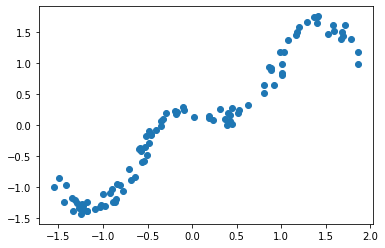

In [21]:
X_train, y_train, X_test, y_test = make_1d_regression(coef=jnp.array([2.0, -4.0]))
plt.figure()

plt.plot(X_train, y_train, 'o')

In [101]:
def make_coef(n_dist = 9, start=2, stop=-2, sf=3):
    c0 = jnp.linspace(start=start, stop=stop, num=n_dist)
    c1 = sf*c0 # jnp.linspace(start=-1, stop=2, num=n_dist)
    coefs = jnp.vstack([c0,c1]).T
    return coefs


def make_regression_tasks(coefs, n_train=100, n_test=100, key=0):
    #c0 = jnp.linspace(start=2, stop=-1, num=n_dist)
    #c1 = jnp.linspace(start=3, stop=-1, num=n_dist)
    #coefs = jnp.vstack([c0,c1]).T
    n_dist = coefs.shape[0]
    def gen(c): return make_1d_regression(coef=c, n_train=n_train, n_test=n_test, key=key)
    X_train, y_train, X_test, y_test  = vmap(gen)(coefs)
    return X_train, y_train, X_test, y_test


def concatenate_tasks(X_train, y_train, X_test, y_test):
    n_dist, n_train, d_train = X_train.shape
    n_dist, n_test, d_test = X_test.shape
    X_train = jnp.hstack(X_train[:,:,0])
    X_test = jnp.hstack(X_test[:,:,0])
    y_train = jnp.hstack(y_train[:,:,0])
    y_test = jnp.hstack(y_test[:,:,0])
    task_id_train = jnp.concatenate([i*jnp.ones(n_train, dtype=int) for i in range(n_dist)])
    task_id_test = jnp.concatenate([i*jnp.ones(n_test, dtype=int) for i in range(n_dist)])
    #return X_train, y_train, X_test, y_test, task_id_train, task_id_test
    return X_train[:,jnp.newaxis], y_train[:,jnp.newaxis], X_test[:,jnp.newaxis], y_test[:,jnp.newaxis], task_id_train, task_id_test

def make_1d_regression_sequence(coefs, n_train=100, n_test=100, key=0):
    X_train, y_train, X_test, y_test = make_regression_tasks(coefs, n_train, n_test, key)
    X_train_seq, y_train_seq, X_test_seq, y_test_seq, train_id_seq, test_id_seq = concatenate_tasks(X_train, y_train, X_test, y_test)
    return X_train_seq, y_train_seq, X_test_seq, y_test_seq, train_id_seq, test_id_seq

In [55]:
def plot_tasks(X_train, Y_train, X_test, Y_test):
    ntasks = X_train.shape[0]
    colors = plt.cm.tab10(np.arange(ntasks) + 1)
    nr = int(np.floor(np.sqrt(ntasks)))
    nc = int(np.ceil(np.sqrt(ntasks)))
    #fig, axs = plt.subplots(1,ntasks, figsize=(20,5))
    fig, axs = plt.subplots(nr, nc, figsize=(10,10))
    axs = axs.flat
    for i in range(ntasks):
        ax = axs[i]
        ax.plot(X_train[i], Y_train[i], 'x', color=colors[i], label='train {:d}'.format(i))
        ax.plot(X_test[i], Y_test[i], 'o', color=colors[i], label='test {:d}'.format(i))
        ax.set_title(i)
    #plt.legend()


def plot_tasks_together(X_train, Y_train, X_test, Y_test, task_id_train, task_id_test):
    ntasks = len(np.unique(task_id_train))
    colors = plt.cm.tab10(np.arange(ntasks) + 1)

    plt.figure()
    for i in range(ntasks):
        ndx_train = (task_id_train == i)
        plt.plot(X_train[ndx_train], Y_train[ndx_train], 'x', color=colors[i], label='train {:d}'.format(i))
        ndx_test = (task_id_test == i)
        plt.plot(X_test[ndx_test], Y_test[ndx_test], 'o', color=colors[i], label='test {:d}'.format(i))
    plt.legend()

def plot_tasks_separately(X_train, Y_train, X_test, Y_test, task_id_train, task_id_test):
    ntasks = len(np.unique(task_id_train))
    colors = plt.cm.tab10(np.arange(ntasks) + 1)
    nr = int(np.floor(np.sqrt(ntasks)))
    nc = int(np.ceil(np.sqrt(ntasks)))
    #fig, axs = plt.subplots(1,ntasks, figsize=(20,5))
    fig, axs = plt.subplots(nr, nc, figsize=(10,10))
    axs = axs.flat
    for i in range(ntasks):
        ax = axs[i]
        ndx_train = (task_id_train == i)
        ax.plot(X_train[ndx_train], Y_train[ndx_train], 'x', color=colors[i], label='train {:d}'.format(i))
        ndx_test = (task_id_test == i)
        ax.plot(X_test[ndx_test], Y_test[ndx_test], 'o', color=colors[i], label='test {:d}'.format(i))
        ax.set_title(i)
    #plt.legend()

[[ 2.   6. ]
 [ 1.5  4.5]
 [ 1.   3. ]
 [ 0.5  1.5]
 [ 0.   0. ]
 [-0.5 -1.5]
 [-1.  -3. ]
 [-1.5 -4.5]
 [-2.  -6. ]]
(9, 100, 1) (9, 100, 1)
(900, 1) (900, 1)


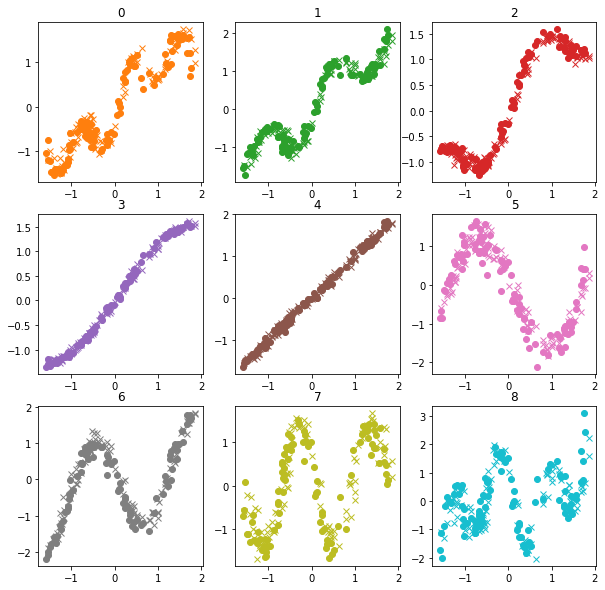

In [100]:
n_dist = 9
c0 = jnp.linspace(start=2, stop=-2, num=n_dist)
c1 = 3*c0 # jnp.linspace(start=-1, stop=2, num=n_dist)
coefs = jnp.vstack([c0,c1]).T

with np.printoptions(precision=3, suppress=True):
    print(coefs)
    
#coefs = make_coef(n_dist = 9)
X_train_tasks, Y_train_tasks, X_test_tasks, Y_test_tasks = make_regression_tasks(coefs, n_train=100, n_test=100, key=0)

X_train_seq, Y_train_seq, X_test_seq, Y_test_seq, train_id_seq, test_id_seq = concatenate_tasks(
    X_train_tasks, Y_train_tasks, X_test_tasks, Y_test_tasks)

print(X_train_tasks.shape, Y_train_tasks.shape)
print(X_train_seq.shape, Y_train_seq.shape)


plot_tasks(X_train_tasks, Y_train_tasks, X_test_tasks, Y_test_tasks)

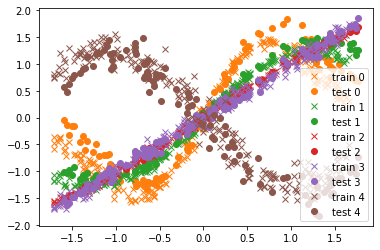

In [12]:
plot_tasks_together(X_train, Y_train, X_test, Y_test, task_id_train, task_id_test)

In [5]:
def plot_pred(Xtr, ytr, Xte, yte, yhat, ysd, ttl=''):
    plt.figure()
    plt.plot(Xtr, ytr, 'o', color="black", label='train')
    plt.plot(Xte, yte, 'x', color="red", label='test')
    plt.plot(Xte, yhat, '*', color="blue", label='pred')
    plt.legend()
    plt.title(ttl)



# Rebayes

In [48]:
class MLP(flax.linen.Module):
    n_out: int
    activation: Callable = flax.linen.tanh
    
    @flax.linen.compact
    def __call__(self, x):
        x = flax.linen.Dense(50)(x)
        x = self.activation(x)
        x = flax.linen.Dense(self.n_out)(x)
        return x

def make_bnn_flax():    
    key = jax.random.PRNGKey(314)
    dim_out = 1
    dim_in = 1 
    model = MLP(dim_out)
    params = model.init(key, jnp.ones((1, dim_in)))
    flat_params, recfn = ravel_pytree(params)
    n_params = len(flat_params)
    #print(n_params)
    return model, flat_params, recfn



(4, 200, 1) (4, 200, 1)
(800, 1) (800, 1)


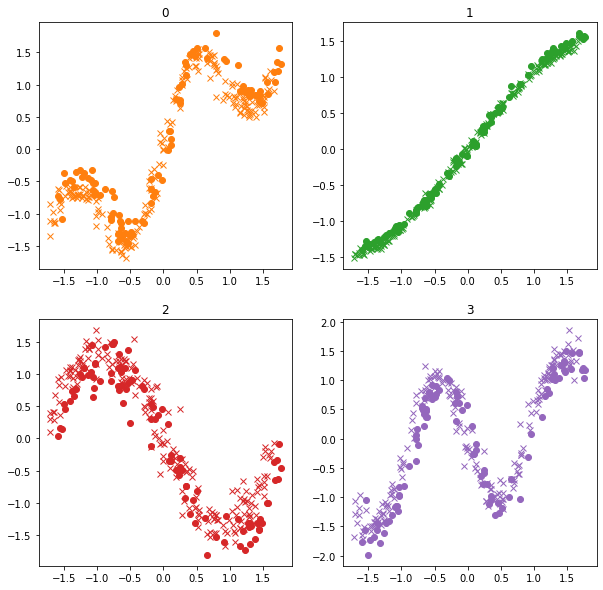

In [111]:
model, flat_params, recfn = make_bnn_flax()

def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), x)

apply_fn = partial(apply, model=model, unflatten_fn=recfn)

params = base.RebayesParams(
        initial_mean=flat_params,
        initial_covariance=0.1,
        dynamics_weights=1,
        dynamics_covariance=0,
        emission_mean_function=apply_fn,
        emission_cov_function = lambda w,x: 0.1,
        adaptive_emission_cov=False,
    )


coefs = make_coef(n_dist = 4, sf=2)
X_train_tasks, Y_train_tasks, X_test_tasks, Y_test_tasks = make_regression_tasks(coefs, n_train=200, n_test=100, key=0)
X_train_seq, Y_train_seq, X_test_seq, Y_test_seq, train_id_seq, test_id_seq = concatenate_tasks(
    X_train_tasks, Y_train_tasks, X_test_tasks, Y_test_tasks)
print(X_train_tasks.shape, Y_train_tasks.shape)
print(X_train_seq.shape, Y_train_seq.shape)

def callback(bel, pred_obs, t, Xt, Yt, bel_pred, **kwargs):
    yhat = apply_fn(bel.mean, X_test_seq).squeeze()
    rmse = jnp.mean(jnp.square(yhat - Y_test_seq[:,0])) # all test set
    task = train_id_seq[t]
    #jax.debug.print("time={t}, task={task}", t=t, task=task)
    #yhat = apply_fn(bel.mean, X_test_tasks[task]).squeeze()
    #rmse = jnp.mean(jnp.square(yhat - Y_test_tasks[task,0])) # current test set
    return rmse

plot_tasks(X_train_tasks, Y_train_tasks, X_test_tasks, Y_test_tasks)

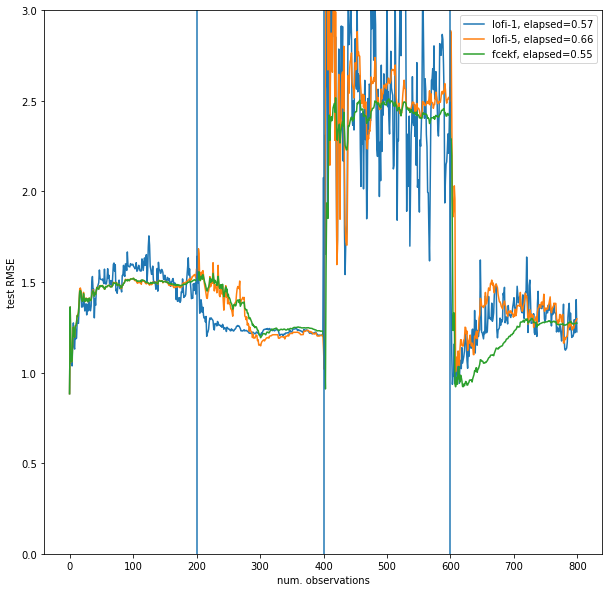

In [113]:
ntasks, ntrain_per_task, _ = X_train_tasks.shape
changepoints = np.arange(ntrain_per_task, (ntasks)*ntrain_per_task, step=ntrain_per_task)

plt.figure(figsize=(10,10))
for i, method in enumerate(method_list):
    ttl = '{:s}, elapsed={:0.2f}'.format(method, elapsed_list[i])
    plt.plot(rmse_trace_list[i], label=ttl)
ntrain = Xtr.shape[0]
#plt.xlim([5, ntrain]) # skip first few steps
plt.ylim([0, 3])
for c in changepoints:
    plt.axvline(x=c)
plt.legend()
plt.ylabel('test RMSE')
plt.xlabel('num. observations')


plt.savefig(figdir + '/regression_plot_1d_lofi.pdf')
plt.savefig(figdir + '/regression_plot_1d_lofi.png')

In [17]:
print(method_list)

i=2 #lofi-5
print(method_list[i])
rmse_trace_lofi = rmse_trace_list[i]
elapsed_lofi = elapsed_list[i]
yhat_lofi = yhat_list[i]

i=4
print(method_list[i])
rmse_trace_vdekf = rmse_trace_list[i]
elapsed_vdekf = elapsed_list[i]
yhat_vdekf = yhat_list[i]

['lofi-1', 'lofi-2', 'lofi-5', 'fcekf', 'vdekf', 'fdekf']
lofi-5
vdekf


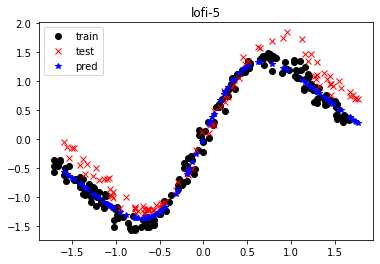

In [18]:


plot_pred(Xtr, ytr, Xte, yte, yhat_lofi, ysd=[], ttl='lofi-5')
plt.savefig(figdir + '/rmse_vs_time_lofi.pdf')
plt.savefig(figdir + '/rmse_vs_time_lofi.png')


# Tyxe

In [19]:
def make_bnn_tyxe():
    nhidden = 50
    net = torch.nn.Sequential(torch.nn.Linear(1, nhidden), torch.nn.Tanh(), torch.nn.Linear(nhidden, 1))
    prior = tyxe.priors.IIDPrior(pyro.distributions.Normal(0, 1))
    #obs_model = tyxe.likelihoods.HomoskedasticGaussian(Ntr, scale=0.1)
    obs_model = tyxe.likelihoods.HomoskedasticGaussian(1, scale=0.1)
    guide = partial(tyxe.guides.AutoNormal, init_scale=0.01)
    #guide = partial(pyro.infer.autoguide.guides.AutoLowRankMultivariateNormal, init_scale=0.01, rank=10)
    bnn = tyxe.VariationalBNN(net, prior, obs_model, guide)
    return bnn

def train_bnn_tyxe(bnn, loader, nepochs=100, lr=1e-3):
    #pyro.clear_param_store()
    optim = pyro.optim.Adam({"lr": lr})
    elbos = []
    def callback(bnn, i, e):
        elbos.append(e)
        
    with tyxe.poutine.local_reparameterization():
        bnn.fit(loader, optim, nepochs, callback)
    return bnn, elbos

def update_prior_tyxe(bnn):
    bayesian_weights = tyxe.util.pyro_sample_sites(bnn)
    posteriors = bnn.net_guide.get_detached_distributions(bayesian_weights)
    bnn.update_prior(tyxe.priors.DictPrior(posteriors))
    return bnn

In [20]:


def scan_tyxe(Xtr, ytr, Xte, yte, batch_size, nepochs_per_batch=100, lr=1e-3):
    pyro.clear_param_store()
    bnn = make_bnn_tyxe()
    Ntr = Xtr.shape[0]
    if type(Xte) is not torch.Tensor: Xte = torch.tensor(Xte)
    if type(yte) is not np.ndarray: yte = yte.detach().numpy()
    nbatches = int(Ntr/batch_size)
    outputs = []
    for b in range(nbatches):
        #print('batch {:d} of {:d}'.format(b, nbatches))
        ndx_train = np.arange(b*batch_size, (b+1)*batch_size)
        Xb, yb = Xtr[ndx_train], ytr[ndx_train]
        dataset = torch.utils.data.TensorDataset(Xtr, ytr)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
        bnn, elbos = train_bnn_tyxe(bnn, loader, nepochs_per_batch, lr)
        yhat, ysd = bnn.predict(Xte, num_predictions=32)
        yhat, ysd = yhat.detach().numpy(), ysd.detach().numpy()
        rmse = np.mean(np.square(yte - yhat))
        outputs.append(rmse)
        bnn = update_prior_tyxe(bnn)
    return np.array(outputs), yhat, ysd

In [21]:
Xtr, ytr, Xte, yte = get_task_data(0)
Xtr_pt, ytr_pt, Xte_pt, yte_pt = torch.tensor(Xtr), torch.tensor(ytr), torch.tensor(Xte), torch.tensor(yte)

In [30]:

bs_list = [10, 20]
nepoch_list = [1, 10]
lr_list = [1e-2, 1e-3]

hparams_list = []

for i, (bs, nepochs, lr) in enumerate(product(bs_list, nepoch_list, lr_list)):
    hparam_dict = {'bs': bs, 'nepochs': nepochs, 'lr': lr}
    hparams_list.append(hparam_dict)

print(hparams_list)


[{'bs': 10, 'nepochs': 1, 'lr': 0.01}, {'bs': 10, 'nepochs': 1, 'lr': 0.001}, {'bs': 10, 'nepochs': 10, 'lr': 0.01}, {'bs': 10, 'nepochs': 10, 'lr': 0.001}, {'bs': 20, 'nepochs': 1, 'lr': 0.01}, {'bs': 20, 'nepochs': 1, 'lr': 0.001}, {'bs': 20, 'nepochs': 10, 'lr': 0.01}, {'bs': 20, 'nepochs': 10, 'lr': 0.001}]


In [31]:
rmse_trace_list_tyxe, elapsed_list_tyxe, yhat_list_tyxe  = [], [], []
for i, hparams in enumerate(hparams_list): 
    print(hparams)  
    pyro.set_rng_seed(42)
    t0 = time.time()
    rmse_trace, yhat, ysd = scan_tyxe(Xtr_pt, ytr_pt, Xte_pt, yte_pt, hparams['bs'], hparams['nepochs'], hparams['lr'])
    yhat_list_tyxe.append(yhat)
    t1 = time.time()
    elapsed = t1-t0
    #print(rmse_trace)
    rmse_trace_list_tyxe.append(rmse_trace)
    elapsed_list_tyxe.append(elapsed)



{'bs': 10, 'nepochs': 1, 'lr': 0.01}
{'bs': 10, 'nepochs': 1, 'lr': 0.001}
{'bs': 10, 'nepochs': 10, 'lr': 0.01}
{'bs': 10, 'nepochs': 10, 'lr': 0.001}
{'bs': 20, 'nepochs': 1, 'lr': 0.01}
{'bs': 20, 'nepochs': 1, 'lr': 0.001}
{'bs': 20, 'nepochs': 10, 'lr': 0.01}
{'bs': 20, 'nepochs': 10, 'lr': 0.001}


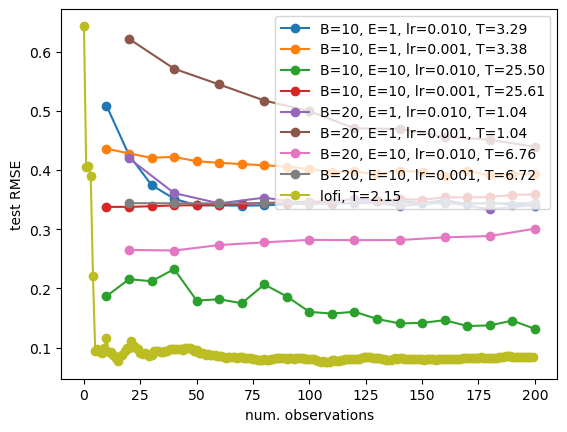

In [42]:
import copy


ntrain = Xtr.shape[0]
method_name_list, ndx_list = [],  []
for i in range(len(hparams_list)):
    hparams = hparams_list[i]
    bs = hparams['bs']
    ndx = np.arange(bs, ntrain+bs, step=bs)
    ndx_list.append(ndx)
    ttl = 'B={:d}, E={:d}, lr={:0.3f}, T={:0.2f}'.format(hparams['bs'], hparams['nepochs'], hparams['lr'], elapsed_list_tyxe[i])
    method_name_list.append(ttl)

ttl = 'lofi-5, T={:0.2f}'.format(elapsed_lofi)
method_name_list.append(ttl)

rmse_list = copy.deepcopy(rmse_trace_list_tyxe)
rmse_list.append(rmse_trace_lofi)
ndx_list.append(np.arange(0, ntrain))


plt.figure()
for i in range(len(rmse_list)):
    ttl = method_name_list[i]
    plt.plot(ndx_list[i], rmse_list[i], 'o-', label=ttl)
plt.ylabel('test RMSE')
plt.xlabel('num. observations')
plt.legend()
plt.savefig(figdir + '/rmse_vs_time.pdf')
plt.savefig(figdir + '/rmse_vs_time.png')



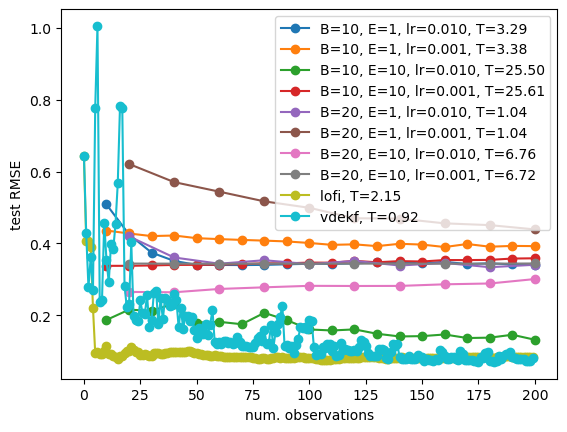

In [43]:

ttl = 'vdekf, T={:0.2f}'.format(elapsed_vdekf)
method_name_list.append(ttl)

rmse_list.append(rmse_trace_vdekf)
ndx_list.append(np.arange(0, ntrain))

plt.figure()
for i in range(len(rmse_list)):
    ttl = method_name_list[i]
    plt.plot(ndx_list[i], rmse_list[i], 'o-', label=ttl)
plt.ylabel('test RMSE')
plt.xlabel('num. observations')
plt.legend()
plt.savefig(figdir + '/rmse_vs_time_vdekf.pdf')
plt.savefig(figdir + '/rmse_vs_time_vdekf.png')

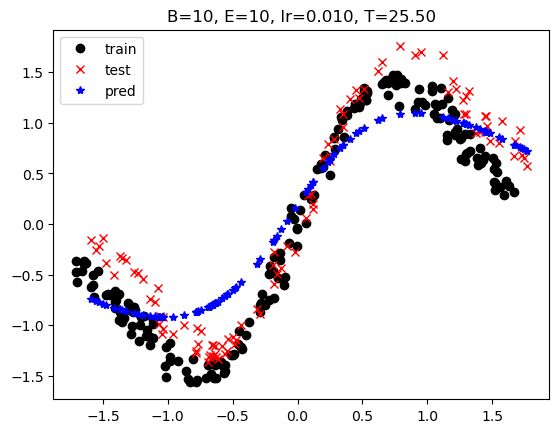

In [45]:
i=2
ttl = method_name_list[i]
yhat = yhat_list_tyxe[i]
plot_pred(Xtr, ytr, Xte, yte, yhat, ysd=[], ttl=ttl)
plt.savefig(figdir + '/regression_plot_1d_vcl.pdf')
plt.savefig(figdir + '/regression_plot_1d_vcl.png')
